## 1. 라이브러리 및 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 분석에 필요한 라이브러리를 불러옵니다.
import pandas as pd

base_path = "/content/drive/MyDrive/Colab Notebooks/data/old files/energy/"


In [3]:
train = pd.read_csv(base_path + "train.csv", encoding="cp949")
test = pd.read_csv(base_path + "test.csv", encoding="cp949")
submission = pd.read_csv(base_path + "sample_submission.csv")

### column별 설명

- num : 건물 번호 (1 ~ 60)


- date_time : 시간 단위


- 전력사용량(kWh) : 시간당 전력사용량 (target) -> Regression!


- 기온, 풍속, 습도, 강수량, 일조 : 기상 정보 (시간당)


- 비전기냉방설비운영, 태양광보유 : categorical feature (0/1) (건물 정보)

In [4]:
#Q. 122400의 의미는?  85 x 60 x 24 = 122400.  || 2020-06-01 ~ 2020-08-24 (85일), 24시간, 60개 건물
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


### column별 설명 (test data)

- 기온, 풍속, 습도, 일조(hr, 3시간) : 3시간당 측정한 값.


- 강수량(mm, 6시간) : 6시간당 측정한 값.


- 비전기냉방설비운영, 태양광보유 : 건물 정보

In [5]:
# Q. 10080은?  10080 = 7 x 24 x 60
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [6]:
# column 이름 변경
train.columns = ["num", "date_time", "target", "temperature",
                "windspeed", "humidity", "precipitation",
                "insolation", "nelec_cool_flag", "solar_flag"]
test.columns = ["num", "date_time", "temperature",
                "windspeed", "humidity", "precipitation",
                "insolation", "nelec_cool_flag", "solar_flag"]

## 2. 데이터 전처리

데이터 전처리할 때, 무조건 해야하는 것. **(No optional)**


- 결측치 처리 : 결측치를 채우거나, 지우거나해서 없애야 함.



- Categorical feature 처리 : object형 column은 무조건 숫자로 변환.

### 2-1. 결측치 처리

#### 건물 정보

In [7]:
#건물별로 '비전기냉방설비운영'과 '태양광보유'를 판단해 test set의 결측치를 보간해줍니다
train[["num", "nelec_cool_flag", "solar_flag"]].drop_duplicates() # --> 건물별로 정보가 똑같다.

,num,nelec_cool_flag,solar_flag
0,1,0.0,0.0
2040,2,1.0,0.0
4080,3,1.0,1.0
6120,4,1.0,1.0
8160,5,1.0,0.0
10200,6,0.0,0.0
12240,7,1.0,0.0
14280,8,1.0,1.0
16320,9,0.0,1.0
18360,10,1.0,0.0


### 좀 더 스마트한 방법으로 채워보기! 

In [8]:
building_info = train[["num", "nelec_cool_flag", "solar_flag"]].drop_duplicates()
building_info

,num,nelec_cool_flag,solar_flag
0,1,0.0,0.0
2040,2,1.0,0.0
4080,3,1.0,1.0
6120,4,1.0,1.0
8160,5,1.0,0.0
10200,6,0.0,0.0
12240,7,1.0,0.0
14280,8,1.0,1.0
16320,9,0.0,1.0
18360,10,1.0,0.0


In [9]:
# JOIN?
test = test.drop(columns=["nelec_cool_flag", "solar_flag"])
test = pd.merge(test, building_info, on=["num"])
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              10080 non-null  int64  
 1   date_time        10080 non-null  object 
 2   temperature      3360 non-null   float64
 3   windspeed        3360 non-null   float64
 4   humidity         3360 non-null   float64
 5   precipitation    1680 non-null   float64
 6   insolation       3360 non-null   float64
 7   nelec_cool_flag  10080 non-null  float64
 8   solar_flag       10080 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 787.5+ KB


#### 기상 정보(강수량, 일조량, 풍속, 기온, 습도)

In [10]:
# 가장 최근에 기록된 정보로 채워줍니다.
test.temperature.interpolate(method="pad")
test.temperature.interpolate(method="linear") # linear interpolation(선형 보간법)
test.temperature.interpolate(method="quadratic")

0        27.800000
1        27.806027
2        27.639360
3        27.300000
4        26.787947
           ...    
10075    28.679729
10076    28.313063
10077    27.900000
10078          NaN
10079          NaN
Name: temperature, Length: 10080, dtype: float64

In [11]:
test.insolation.value_counts()

0.0    1872
0.1     120
3.0     102
0.6      83
0.2      74
0.9      71
0.5      63
1.0      62
1.2      60
0.3      57
1.6      55
2.7      54
1.8      53
0.4      49
1.1      49
2.8      46
2.4      45
1.4      42
1.3      40
2.2      40
0.7      39
0.8      37
2.0      36
2.9      35
2.1      29
1.5      29
2.6      26
1.9      26
1.7      25
2.3      24
2.5      17
Name: insolation, dtype: int64

In [12]:
import numpy as np

mask = []
for i in range(len(train)):
    if i % 3 == 0:
        mask.append(1)
    else:
        mask.append(0)
mask = np.array(mask)

In [13]:
dummy = train.copy() # 실험용 train data를 하나 복사합니다.
# Q. dummy를 test data처럼 빈 칸을 뚫습니다.
## (풍속, 기온, 일조량, 습도는 3칸마다 데이터가 있고, 강수량은 6칸마다 데이터가 있습니다.)
### make_train_nan 함수를 이용해서 dummy dataframe을 스펀지로 만들어주세요!
# HINT : np.nan 사용하기

def make_train_nan(data, columns, n):
    # data : 스펀지를 만들 원본 dataframe
    # columns : 스펀지를 만들 대상 columns
    # n : 몇번째마다 값을 둘 것인가  (3 or 6)
    # mask = [i % n != 0 for i in range(len(data))]
    # data.loc[mask, columns] = np.nan
    data.loc[data.index % n != 0, columns] = np.nan

make_train_nan(dummy, ["humidity", "temperature", "insolation", "windspeed"], 3)
make_train_nan(dummy, ["precipitation"], 6)
dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   num              122400 non-null  int64  
 1   date_time        122400 non-null  object 
 2   target           122400 non-null  float64
 3   temperature      40800 non-null   float64
 4   windspeed        40800 non-null   float64
 5   humidity         40800 non-null   float64
 6   precipitation    20400 non-null   float64
 7   insolation       40800 non-null   float64
 8   nelec_cool_flag  122400 non-null  float64
 9   solar_flag       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [14]:
dummy

,num,date_time,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2020-06-01 02,8107.128,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,NaN,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,NaN,NaN,NaN,NaN,NaN,1.0,1.0
122396,60,2020-08-24 20,3975.696,NaN,NaN,NaN,NaN,NaN,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,NaN,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [15]:
def compare_interpolation_methods(train, dummy, column, methods, metric):
    # train, dummy : 비교 대상
    # column : 비교 대상에 해당하는 column
    # methods : interpolation methods ("pad", "linear", "quadratic")
    # metric : 비교를 하는 기준 (MAE, MSE)
    error_dict = {}

    for method in methods:
        if method == "quadratic":
            temp = dummy[column].interpolate(method=method).interpolate("linear") # 마지막에 비어있는 NaN 채우기.
            error_dict[method] = metric(train[column], temp) # error를 계산
        else:
            temp = dummy[column].interpolate(method=method) # 특정 column을 주어진 방식으로 interpolate
            error_dict[method] = metric(train[column], temp) # error를 계산
        
    return error_dict

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 1. interpolation 기법별로 에러(틀린 정도)를 계산합니다.
all_error_dict = {}
#metric = mean_absolute_error
metric = mean_squared_error

for column in ["humidity", "windspeed", "temperature", "insolation", "precipitation"]:
    methods = ["pad", "linear", "quadratic"]
    error_dict = compare_interpolation_methods(train, dummy, column, methods, metric)
    all_error_dict[column] = error_dict
# 2. 계산 결과를 그래프로 그립니다.
all_error_df = pd.DataFrame(all_error_dict)
all_error_df

,humidity,windspeed,temperature,insolation,precipitation
pad,21.611516,0.548216,0.926506,0.045982,7.620644
linear,5.530952,0.326506,0.167137,0.016300,4.934571
quadratic,5.433766,0.365934,0.158510,0.017218,5.506180


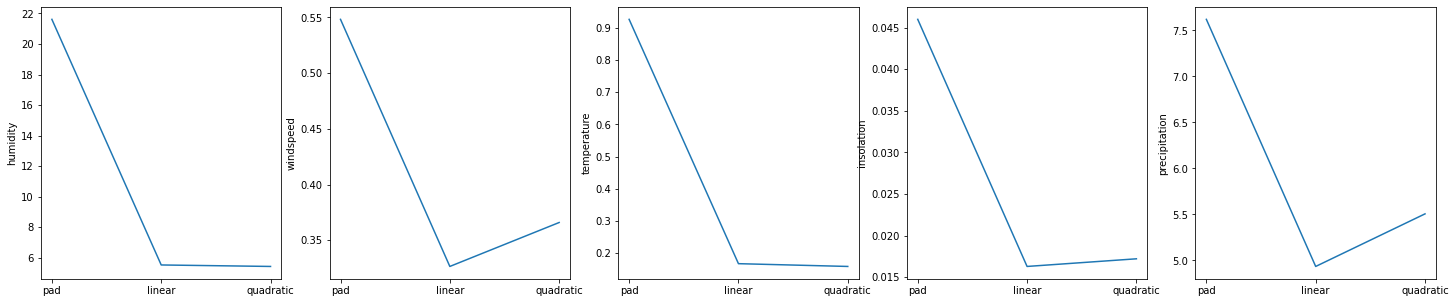

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 5, figsize = (25, 5))
for i in range(len(all_error_df.columns)):
    sns.lineplot(ax=axes[i], data=all_error_df.iloc[:, i].transpose(), sort=False)

In [18]:
# 테스트 데이터에 결측치를 채워봅니다!
test.temperature = test.temperature.interpolate(method="quadratic")
# 마지막 NaN을 채우기 위해서 linear interpolation을 적용해줍니다.
test.temperature = test.temperature.interpolate(method="linear")

test.windspeed = test.windspeed.interpolate(method="linear")

test.humidity = test.humidity.interpolate(method="quadratic")
# 마지막 NaN을 채우기 위해서 linear interpolation을 적용해줍니다.
test.humidity = test.humidity.interpolate(method="linear")

test.precipitation = test.precipitation.interpolate(method="linear")

test.insolation = test.insolation.interpolate(method="linear")

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              10080 non-null  int64  
 1   date_time        10080 non-null  object 
 2   temperature      10080 non-null  float64
 3   windspeed        10080 non-null  float64
 4   humidity         10080 non-null  float64
 5   precipitation    10080 non-null  float64
 6   insolation       10080 non-null  float64
 7   nelec_cool_flag  10080 non-null  float64
 8   solar_flag       10080 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 787.5+ KB


In [20]:
#요일 변수를 추가해봅니다.
def weekday(x):


SyntaxError: ignored

+ test 결측치를 채워봅니다.
+ test 데이터의 변수는 예보 데이터이며, 예보 데이터는 train 데이터의 기간에 생성된 것이기에 활용 가능합니다.

1) 평균으로 채우기


2) 최빈값으로 채우기


3) 근처(앞, 뒤)에 있는 값으로 채우기


4) interpolation

### 2-2. 상관관계 분석

In [ ]:
# 피처간 비슷한 변수들이 있는지 확인하기 위해 상관관계 분석을 수행합니다.


In [ ]:
# heatmap


In [ ]:
# 피처간 비슷한 변수들이 있는지 확인하기 위해 상관관계 분석을 수행합니다.
corr = []
for num in range(1,61):
    df = train[train.num==num]
    num_corr = df.corr()['target']
    num_corr = num_corr.drop(['num','nelec_cool_flag','solar_flag','target'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,61))

# 시각화
f, ax = plt.subplots(figsize=(20,8))
plt.title("Correlation between features and target", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('Building(num)')
plt.show()

### 2-3. 이상치 검출

1) IQR(Inter-Quantile Range)


2) Outlier Detection method (e.g. Isolation Forest)

### IQR 

In [ ]:
# 데이터 중에 전체 데이터의 패턴을 벗어나는 데이터가 있는지 확인합니다.
def get_outlier(data, column, weight=1.5):
    

    
    
    print("IQR은 %.2f이다." % IQR)
    print(f"lower_bound는 {lower_bound:.2f}이다.") # f-string
    print("upper_bound는 {:.2f}이다.".format(upper_bound))
    

    return outlier_idx

In [ ]:
selected_col = input("Which column ? ")
outlier_idx = get_outlier(train, selected_col)
train.loc[outlier_idx, :]

In [ ]:
# outlier detection
# anomaly detection

train.drop(outlier_idx)

### Isolation Forest (ML Model)

In [ ]:
from sklearn.ensemble import IsolationForest

X = train.drop(columns=["num", "date_time", "target"])

model = 

In [ ]:
# IsolationForest로 판단한 outlier들을 제거합니다


## 3. 예측 모델 구현

In [21]:
# 전력사용량 예측을 위해 회귀 모델을 불러옵니다
from lightgbm.sklearn import LGBMRegressor

In [22]:
# 학습에 필요한 데이터셋을 만듭니다
X = train.drop(columns=["num", "date_time", "target"])
y = train.target

In [24]:
# 학습 및 모델 검증을 위해 KFold Cross Validation 기법을 사용합니다.
from sklearn.model_selection import KFold

K = int(input("K? : "))
print_mode = False

cv = KFold(n_splits=K, shuffle=True, random_state=42)
reg = LGBMRegressor()

# 모델별 fold
folds = []
scores = []

# K-fold 생성.
for train_idx, valid_idx in cv.split(X, y):
    folds.append((train_idx, valid_idx))

# fold별 학습 및 검증
for i in range(K):
    if print_mode:
        print(f"{i+1}th folds in {K} folds.")
    
    train_idx, valid_idx = folds[i] # unpacking
    
    X_train = X.iloc[train_idx, :]
    X_val = X.iloc[valid_idx, :]
    y_train = y[train_idx]
    y_val = y[valid_idx]

    reg.fit(X_train, y_train)
    pred = reg.predict(X_val)
    score = mean_absolute_error(y_val, pred)
    scores.append(score)
    
print("CV Results : ", np.mean(scores))

K? : 5
CV Results :  1236.5024970200136


In [25]:
# training
# reg = LGBMRegressor()
# reg.fit(X, y)
pred = reg.predict(X)
mean_absolute_error(y, pred)

1220.5033527094051

In [26]:
# submission 파일 생성
X_test = test.drop(columns=["num", "date_time"])
output = reg.predict(X_test)

In [27]:
submission["answer"] = output
submission.to_csv("submission.csv", index=False)